In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)
from keras.models import load_model, Model
from keras.layers import SimpleRNN, Dense, Input, Dropout, LSTM, Activation, Embedding, Bidirectional
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')
nltk.download('punkt')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
!pip install beautifulsoup4

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Read in data from CSV
original_training_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/train.csv')
evaluation = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/eval.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
evaluation['email'] = evaluation['email'].str.lower()

In [6]:
# View the CSV
original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


In [0]:
[train, test] = train_test_split(original_training_data, test_size=0.1, random_state=42)

In [0]:
stop_words = set(stopwords.words('english')) 
def remove_stopwords(x):
  word_tokens = word_tokenize(x) 
  filtered_sentence = [w for w in word_tokens if not w in stop_words] 
  return ' '.join(filtered_sentence)

In [0]:
def clean_data(data):
  df = data.copy()
  df['subject'] = data['subject'].fillna("")
  df['subject'] = df['subject'].str.replace("Subject:", "", regex=False)
  df['email'] = df['subject'] + df['email']
  df['email'] = df['email'].apply(lambda x: BeautifulSoup(x).get_text())
  df['email'] = df['email'].apply(lambda x: x.strip())
  df['email'] = df['email'].apply(remove_stopwords)
  df['email'] = df['email'].str.replace(r'\d+(\.\d+)?', 'numbr', regex=True) 
  return df


In [0]:
def get_plot(history_dict):
  # Loss
  training_loss_values = history_dict['loss']
  validation_loss_values = history_dict['val_loss']

  epochs = range(1, len(training_loss_values) + 1)

  plt.figure(figsize=(15, 5)) #(width, height)

  plt.subplot(1, 2, 1)
  plt.plot(epochs, training_loss_values, 'r', label='Training loss')
  plt.plot(epochs, validation_loss_values, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Accuracy
  training_accuracy_values = history_dict['acc']
  validation_accuracy_values = history_dict['val_acc']

  plt.subplot(1, 2, 2)
  plt.plot(epochs, training_accuracy_values, 'r', label='Training accuracy')
  plt.plot(epochs, validation_accuracy_values, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()

  return plt

In [0]:
clean_train = clean_data(train)
clean_test = clean_data(test)

In [20]:
clean_train.email.map(len).max()

341030

In [0]:
training_sentences = clean_train['email'].to_numpy()
training_labels = clean_train['spam'].to_numpy()

testing_sentences = clean_test['email'].to_numpy()
testing_labels = clean_test['spam'].to_numpy()

In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

vocab_size = 500 # only the top 500 most frequent words
embedding_dim = 100
max_length = 500
trunc_type = 'post'
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)

# Dictionary mapping words to their index
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type)

print('Found %s unique tokens.' % len(word_index))

test_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(test_sequences, maxlen = max_length, truncating = trunc_type)

Found 94931 unique tokens.


Lets examine the words that the tokenization found.
Unfortunately, due to the way tokenization works, word_index contains tokens for all unique words, despite our vocab_size. When we use tokenizer later to token our text, only the most common vocab_size (500) words will be used. 
So for now, as a quick solution, we can filter the words by index to get the most frequent words

In [23]:
for word, index in word_index.items():
  if index < vocab_size + 1:
    print (word, index)

<OOV> 1
numbr 2
e 3
'' 4
n 5
r 6
http 7
com 8
c 9
's 10
l 11
f 12
h 13
p 14
w 15
www 16
b 17
n't 18
g 19
list 20
net 21
numbrd 22
one 23
get 24
u 25
email 26
free 27
linux 28
new 29
' 30
mail 31
numbre 32
anumbr 33
time 34
use 35
lists 36
would 37
like 38
people 39
click 40
re 41
v 42
html 43
content 44
users 45
us 46
bnumbr 47
font 48
information 49
listinfo 50
dnumbr 51
message 52
d 53
please 54
make 55
mailing 56
also 57
text 58
spamassassin 59
business 60
k 61
x 62
cnumbr 63
color 64
ie 65
web 66
mailman 67
money 68
org 69
want 70
z 71
could 72
work 73
see 74
first 75
exmh 76
software 77
numbrc 78
wrote 79
may 80
way 81
internet 82
address 83
razor 84
rpm 85
'm 86
world 87
ilug 88
spam 89
've 90
sourceforge 91
know 92
home 93
size 94
even 95
news 96
send 97
need 98
system 99
type 100
said 101
numbrp 102
name 103
date 104
much 105
find 106
using 107
go 108
right 109
many 110
well 111
company 112
s 113
think 114
're 115
url 116
good 117
file 118
'll 119
help 120
group 121
ca 122
repo

In [0]:
embeddings_index = {}
f = open('/content/drive/My Drive/Colab Notebooks/data/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim)) # +1 to account for the <OOV> token
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [28]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights = [embedding_matrix],
                            input_length = max_length,
                            trainable = False)

In [29]:
tokenized_mail = Input(shape=(max_length,), dtype='int32')

embedded_sequences = embedding_layer(tokenized_mail)
x = Bidirectional(LSTM(64, return_sequences = True))(embedded_sequences)
# x = Dropout(rate = 0.5 )(x)
x = Bidirectional(LSTM(32))(x)
# x = Dropout(rate = 0.5 )(x)
x = Dense(64, activation = 'relu')(x)
# x = Dropout(rate = 0.5 )(x)
x = Dense(1, activation = 'sigmoid')(x)

model = Model(inputs = tokenized_mail, outputs = x)

In [30]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 100)          9493200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 128)          84480     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,623,121
Trainable params: 129,921
Non-trainable params: 9,493,200
___________________________________________

In [31]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [32]:
history = model.fit(padded, 
            training_labels, 
            epochs = 10, 
            batch_size=256,
            validation_data = (testing_padded, testing_labels))



Train on 7513 samples, validate on 835 samples
Epoch 1/10
7513/7513 [==============================] - 86s 11ms/step - loss: 0.5429 - acc: 0.7307 - val_loss: 0.4268 - val_acc: 0.8084
Epoch 2/10
7513/7513 [==============================] - 82s 11ms/step - loss: 0.3140 - acc: 0.8700 - val_loss: 0.2241 - val_acc: 0.9150
Epoch 3/10
7513/7513 [==============================] - 81s 11ms/step - loss: 0.1818 - acc: 0.9295 - val_loss: 0.2521 - val_acc: 0.9114
Epoch 4/10
7513/7513 [==============================] - 81s 11ms/step - loss: 0.1629 - acc: 0.9432 - val_loss: 0.1782 - val_acc: 0.9425
Epoch 5/10
7513/7513 [==============================] - 81s 11ms/step - loss: 0.1291 - acc: 0.9549 - val_loss: 0.1559 - val_acc: 0.9437
Epoch 6/10
7513/7513 [==============================] - 80s 11ms/step - loss: 0.1302 - acc: 0.9571 - val_loss: 0.1464 - val_acc: 0.9497
Epoch 7/10
7513/7513 [==============================] - 80s 11ms/step - loss: 0.1178 - acc: 0.9610 - val_loss: 0.1469 - val_acc: 0.9449

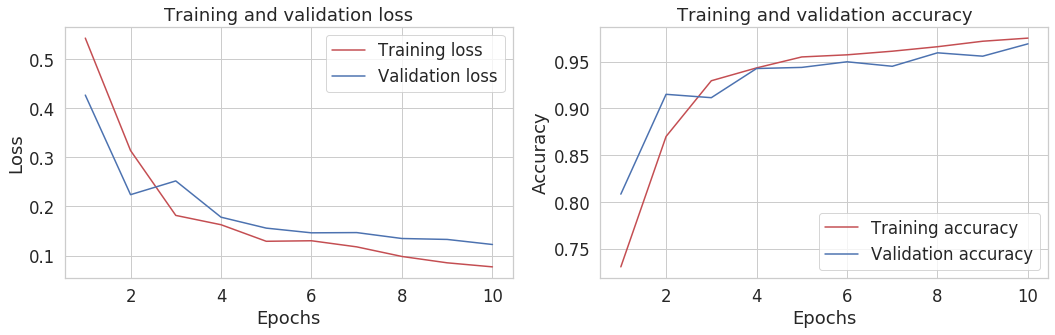

In [35]:
# View the training and validation loss & accuracy
plt = get_plot(history.history)
plt.show()

In [0]:
from google.colab import files

def download_model(model, model_name):
  model_name = str(model_name) + '.h5'

  model.save(model_name)
  files.download(model_name)

In [0]:
clean_eval = clean_data(evaluation)
eval_sentences = clean_eval['email'].to_numpy()
eval_sequences = tokenizer.texts_to_sequences(eval_sentences)
eval_padded = pad_sequences(eval_sequences, maxlen = max_length, truncating = trunc_type)

In [37]:
clean_eval.head()

,id,subject,email
0,0,CERT Advisory CA-2002-21 Vulnerability in PHP\n,CERT Advisory CA-numbr-numbr Vulnerability PHP...
1,1,ADV: Affordable Life Insurance ddbfk\n,ADV : Affordable Life Insurance ddbfk low-cost...
2,2,CAREER OPPORTUNITY. WORK FROM HOME\n,CAREER OPPORTUNITY . WORK FROM HOME -- -- -- =...
3,3,Marriage makes both sexes happy\n,Marriage makes sexes happy url : http : //www....
4,4,Re: [SAtalk] SA very slow (hangs?) on this me...,"Re : [ SAtalk ] SA slow ( hangs ? ) message , ..."


In [0]:
def process_predictions(predictions):
  evaluation_predictions = np.where(predictions >= 0.5, 1, 0)
  evaluation_predictions.shape
  evaluation_predictions = np.squeeze(evaluation_predictions)
  evaluation_predictions.shape

  return evaluation_predictions

In [0]:
predicted_labels = model.predict(eval_padded)

predicted_labels[:5]

evaluation_predictions = process_predictions(predicted_labels)

In [0]:
from datetime import datetime
from google.colab import files

def download_kaggle_submission(evaluation_predictions):

  # Assuming that your predictions on the evaluation set are stored in a 1-dimensional array called
  # evaluation_predictions. Feel free to modify this cell as long you create a CSV in the right format.

  # must be ndarray of predictions
  assert isinstance(evaluation_predictions, np.ndarray) 

  # must be binary labels (0 or 1) and not probabilities
  assert np.all((evaluation_predictions == 0) | (evaluation_predictions == 1))

  # must be the right number of predictions
  assert evaluation_predictions.shape == (1000, )

  # Construct and save the submission:
  submission_df = pd.DataFrame({
      "Id": evaluation['id'], 
      "Class": evaluation_predictions,
  }, columns=['Id', 'Class'])

  timestamp = datetime.isoformat(datetime.now()).split(".")[0]
  submission_file_name = "submission_{}.csv".format(timestamp)

  submission_df.to_csv(submission_file_name, index=False)

  print('Downloading CSV file: {}.'.format(submission_file_name))
  print('You may now upload this CSV file to Kaggle for scoring.')

  files.download(submission_file_name)

In [41]:
download_kaggle_submission(evaluation_predictions)

You may now upload this CSV file to Kaggle for scoring.
